# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1TMC5S3aSY8JDRbc2BIocF_VtBERrGHXR/view?usp=sharing

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [14]:
# for line in open('SMSSpamCollection'):
#     break

for line in open('SMSSpamCollection'):
    if line[0] == 's':
        print(line)
        print("Non-spam label is: ", line.split()[0], "\n")
        break
for line in open('SMSSpamCollection'):
    if line[0] == 'h':
        print(line)
        print("Spam label is: ", line.split()[0], "\n")
        break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Non-spam label is:  spam 

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam label is:  ham 



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [15]:
numSpam = 0
numHam = 0

for line in open('SMSSpamCollection'):
    if line.split()[0] == "spam":
        numSpam = numSpam + 1
    else:
        numHam = numHam + 1

print("There are", numSpam, "spam messages in the data set.")
print("There are", numHam, "ham messages in the data set.")

There are 747 spam messages in the data set.
There are 4827 ham messages in the data set.


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [16]:
# load data
data = []
labels = []

with open('SMSSpamCollection', 'r', encoding='utf-8') as f:
    for line in f:
        label, text = line.strip().split('\t', 1)
        data.append(text)
        labels.append(1 if label == "spam" else 0)

# build character-level vocabulary
all_text = ''.join(data)
vocab = sorted(set(all_text))

# reserve 0 for padding
stoi = {ch: idx + 1 for idx, ch in enumerate(vocab)}
stoi['<PAD>'] = 0

# create inverse mapping
itos = {idx: ch for ch, idx in stoi.items()}

# convert text data to list of character indices
sequences = [[stoi[ch] for ch in message] for message in data]

### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [17]:
from sklearn.model_selection import train_test_split

# 60-20-20 split
X_temp, test_x, y_temp, test_y = train_test_split(sequences, labels, test_size=0.2, stratify=labels, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)  # 0.25 x 0.8 = 0.2

# balance the training set by oversampling spam messages
train_x_balanced = train_x.copy()
train_y_balanced = train_y.copy()

# get all spam messages from training set
spam_x = [x for x, y in zip(train_x, train_y) if y == 1]

# duplicate each spam message 6 times
train_x_balanced.extend(spam_x * 6)
train_y_balanced.extend([1] * len(spam_x) * 6)

### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [18]:
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

# custom collate_fn using pad_sequence
def collate_sequences(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.float)
    return padded_sequences, labels

train_loader = DataLoader(dataset=MyDataset(train_x_balanced, train_y_balanced), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(dataset=MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(dataset=MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [21]:
pad_token = 0

for i, (batch_sequences, batch_labels) in enumerate(train_loader):
    if i >= 10:
        break

    max_seq_len = batch_sequences.shape[1]
    num_pad_tokens = (batch_sequences == pad_token).sum().item()

    print(f"Batch {i+1}:")
    print(f"  Max sequence length: {max_seq_len}")
    print(f"  Number of <pad> tokens: {num_pad_tokens}")


Batch 1:
  Max sequence length: 220
  Number of <pad> tokens: 3615
Batch 2:
  Max sequence length: 160
  Number of <pad> tokens: 1437
Batch 3:
  Max sequence length: 297
  Number of <pad> tokens: 5724
Batch 4:
  Max sequence length: 161
  Number of <pad> tokens: 1373
Batch 5:
  Max sequence length: 191
  Number of <pad> tokens: 2958
Batch 6:
  Max sequence length: 185
  Number of <pad> tokens: 2785
Batch 7:
  Max sequence length: 163
  Number of <pad> tokens: 1678
Batch 8:
  Max sequence length: 444
  Number of <pad> tokens: 9935
Batch 9:
  Max sequence length: 160
  Number of <pad> tokens: 1809
Batch 10:
  Max sequence length: 221
  Number of <pad> tokens: 3726


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

In [36]:
class SpamClassifierRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim=64, rnn_type='GRU'):
        super(SpamClassifierRNN, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim

        # one-hot embedding using identity matrix
        self.register_buffer('one_hot_embed', torch.eye(vocab_size))

        # RNN layer
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)

        # single linear layer for binary classification
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.one_hot_embed[x]  # shape: (batch_size, seq_len, vocab_size)
        out, _ = self.rnn(x)       # shape: (batch_size, seq_len, hidden_dim)

        last_hidden = out[:, -1, :]  # use the final time step
        return self.fc(last_hidden).squeeze()

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [28]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data:
            outputs = model(inputs)
            preds = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total if total > 0 else 0

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [29]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_acc = get_accuracy(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.tight_layout()
    plt.show()

def evaluate(model, data_loader, criterion):
    model.eval()
    loss_total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_total += loss.item()

    accuracy = get_accuracy(model, data_loader)
    return loss_total / len(data_loader), accuracy


Epoch 1/10 Train Loss: 0.6024 | Train Acc: 0.8929 | Val Loss: 0.3542 | Val Acc: 0.9238
Epoch 2/10 Train Loss: 0.3501 | Train Acc: 0.9287 | Val Loss: 0.2476 | Val Acc: 0.9570
Epoch 3/10 Train Loss: 0.2463 | Train Acc: 0.9327 | Val Loss: 0.1957 | Val Acc: 0.9605
Epoch 4/10 Train Loss: 0.2325 | Train Acc: 0.9299 | Val Loss: 0.3456 | Val Acc: 0.9085
Epoch 5/10 Train Loss: 0.3822 | Train Acc: 0.9014 | Val Loss: 0.3386 | Val Acc: 0.8664
Epoch 6/10 Train Loss: 0.2571 | Train Acc: 0.9355 | Val Loss: 0.3483 | Val Acc: 0.9049
Epoch 7/10 Train Loss: 0.1944 | Train Acc: 0.9488 | Val Loss: 0.2511 | Val Acc: 0.9247
Epoch 8/10 Train Loss: 0.1620 | Train Acc: 0.9481 | Val Loss: 0.2262 | Val Acc: 0.9291
Epoch 9/10 Train Loss: 0.1476 | Train Acc: 0.9640 | Val Loss: 0.1152 | Val Acc: 0.9695
Epoch 10/10 Train Loss: 0.1276 | Train Acc: 0.9677 | Val Loss: 0.1177 | Val Acc: 0.9659


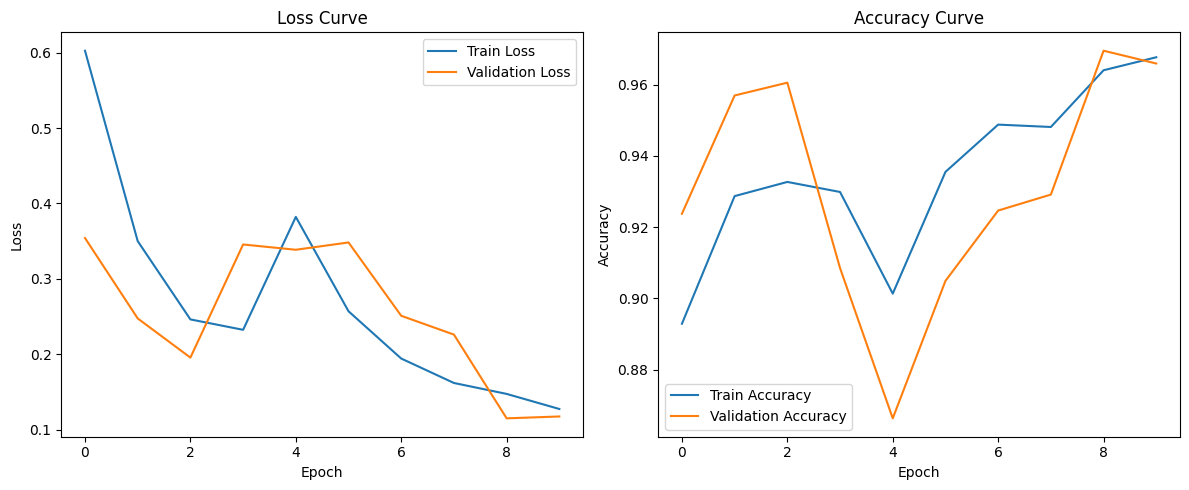

In [37]:
model1 = SpamClassifierRNN(vocab_size=len(stoi), hidden_dim=64)
train_model(model1, train_loader, val_loader, num_epochs=10, learning_rate=0.001)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [42]:
def train_model_wo_plot(model, train_x, train_y, val_x, val_y, num_epochs=10,
                        batch_size=32, learning_rate=0.001):
    train_loader = DataLoader(MyDataset(train_x, train_y), batch_size=batch_size,
                              shuffle=True, collate_fn=collate_sequences)
    val_loader = DataLoader(MyDataset(val_x, val_y), batch_size=batch_size,
                            shuffle=False, collate_fn=collate_sequences)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_acc = get_accuracy(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


In [40]:
# I will first try to increase the number of neurons in the hidden layer to 128
# hoping the model can discover more features on the data. I will also increase
# the number of epochs to 15 as I saw from part (b) that the model still has
# potential to improve its accuracy if being run for longer.
model2 = SpamClassifierRNN(vocab_size=len(stoi), hidden_dim=128)
train_model_wo_plot(model2, train_x_balanced, train_y_balanced,
                    val_x, val_y, num_epochs=15)

Epoch 1/15 Train Loss: 0.5419 | Train Acc: 0.9314 | Val Loss: 0.2705 | Val Acc: 0.9570
Epoch 2/15 Train Loss: 0.2227 | Train Acc: 0.9425 | Val Loss: 0.1618 | Val Acc: 0.9704
Epoch 3/15 Train Loss: 0.2008 | Train Acc: 0.9423 | Val Loss: 0.1573 | Val Acc: 0.9740
Epoch 4/15 Train Loss: 0.1983 | Train Acc: 0.9421 | Val Loss: 0.1609 | Val Acc: 0.9749
Epoch 5/15 Train Loss: 0.1871 | Train Acc: 0.9448 | Val Loss: 0.1568 | Val Acc: 0.9722
Epoch 6/15 Train Loss: 0.1535 | Train Acc: 0.9587 | Val Loss: 0.1468 | Val Acc: 0.9713
Epoch 7/15 Train Loss: 0.1255 | Train Acc: 0.9639 | Val Loss: 0.1486 | Val Acc: 0.9453
Epoch 8/15 Train Loss: 0.1172 | Train Acc: 0.9668 | Val Loss: 0.1015 | Val Acc: 0.9767
Epoch 9/15 Train Loss: 0.0798 | Train Acc: 0.9798 | Val Loss: 0.1080 | Val Acc: 0.9632
Epoch 10/15 Train Loss: 0.5506 | Train Acc: 0.5913 | Val Loss: 0.6791 | Val Acc: 0.6287
Epoch 11/15 Train Loss: 0.6596 | Train Acc: 0.5986 | Val Loss: 0.7227 | Val Acc: 0.2789
Epoch 12/15 Train Loss: 0.5361 | Train Ac

In [43]:
# The model is performing about the same in the end. Now I will try to decrease
# the batch size to 16 and the learning rate to 5e-5, hoping the model will
# generalize better by updating more gradually and having more frequent weight
# updates.
model3 = SpamClassifierRNN(vocab_size=len(stoi), hidden_dim=128)
train_model_wo_plot(model3, train_x_balanced, train_y_balanced, val_x, val_y,
                    num_epochs=15, batch_size=16, learning_rate=0.0005)

Epoch 1/15 Train Loss: 0.4696 | Train Acc: 0.9324 | Val Loss: 0.1921 | Val Acc: 0.9587
Epoch 2/15 Train Loss: 0.3871 | Train Acc: 0.9360 | Val Loss: 0.1919 | Val Acc: 0.9623
Epoch 3/15 Train Loss: 0.1953 | Train Acc: 0.9428 | Val Loss: 0.1587 | Val Acc: 0.9713
Epoch 4/15 Train Loss: 0.1877 | Train Acc: 0.9547 | Val Loss: 0.1734 | Val Acc: 0.9570
Epoch 5/15 Train Loss: 0.1772 | Train Acc: 0.9609 | Val Loss: 0.1431 | Val Acc: 0.9704
Epoch 6/15 Train Loss: 0.1514 | Train Acc: 0.9431 | Val Loss: 0.3111 | Val Acc: 0.9211
Epoch 7/15 Train Loss: 0.1743 | Train Acc: 0.9534 | Val Loss: 0.1238 | Val Acc: 0.9695
Epoch 8/15 Train Loss: 0.1413 | Train Acc: 0.9617 | Val Loss: 0.1264 | Val Acc: 0.9668
Epoch 9/15 Train Loss: 0.1297 | Train Acc: 0.9650 | Val Loss: 0.1231 | Val Acc: 0.9704
Epoch 10/15 Train Loss: 0.1240 | Train Acc: 0.9675 | Val Loss: 0.1071 | Val Acc: 0.9722
Epoch 11/15 Train Loss: 0.1147 | Train Acc: 0.9695 | Val Loss: 0.1024 | Val Acc: 0.9731
Epoch 12/15 Train Loss: 0.1132 | Train Ac

In [44]:
# The model is performing about the same again. Now I will try to use two
# recurrent layers, which means there will be a stacked RNN. This may allow the
# model to capture deeper sequential patterns by allowing the second layer to
# interpret features extracted by the first.
class StackedRNN(SpamClassifierRNN):
    def __init__(self, vocab_size, hidden_dim=128, rnn_type='GRU', num_layers=2):
        super(StackedRNN, self).__init__(vocab_size, hidden_dim, rnn_type)
        self.rnn = nn.GRU(input_size=vocab_size, hidden_size=hidden_dim,
                          num_layers=num_layers, batch_first=True)

model4 = StackedRNN(vocab_size=len(stoi), hidden_dim=128)
train_model_wo_plot(model4, train_x_balanced, train_y_balanced, val_x, val_y,
                    num_epochs=15, batch_size=16, learning_rate=0.0005)

Epoch 1/15 Train Loss: 0.4362 | Train Acc: 0.9484 | Val Loss: 0.2129 | Val Acc: 0.9390
Epoch 2/15 Train Loss: 0.4099 | Train Acc: 0.5201 | Val Loss: 0.8707 | Val Acc: 0.1354
Epoch 3/15 Train Loss: 0.4850 | Train Acc: 0.9352 | Val Loss: 0.1835 | Val Acc: 0.9632
Epoch 4/15 Train Loss: 0.1691 | Train Acc: 0.9592 | Val Loss: 0.1178 | Val Acc: 0.9605
Epoch 5/15 Train Loss: 0.1162 | Train Acc: 0.9658 | Val Loss: 0.1110 | Val Acc: 0.9650
Epoch 6/15 Train Loss: 0.0986 | Train Acc: 0.9710 | Val Loss: 0.0926 | Val Acc: 0.9758
Epoch 7/15 Train Loss: 0.0961 | Train Acc: 0.9695 | Val Loss: 0.1078 | Val Acc: 0.9677
Epoch 8/15 Train Loss: 0.0800 | Train Acc: 0.9823 | Val Loss: 0.0995 | Val Acc: 0.9740
Epoch 9/15 Train Loss: 0.0864 | Train Acc: 0.9808 | Val Loss: 0.1152 | Val Acc: 0.9713
Epoch 10/15 Train Loss: 0.0762 | Train Acc: 0.9818 | Val Loss: 0.1038 | Val Acc: 0.9758
Epoch 11/15 Train Loss: 0.0646 | Train Acc: 0.9847 | Val Loss: 0.1002 | Val Acc: 0.9740
Epoch 12/15 Train Loss: 0.0610 | Train Ac

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [49]:
def get_false_positive_negative_rate(model, val_x, val_y, batch_size=16):
    val_loader = DataLoader(MyDataset(val_x, val_y), batch_size=batch_size,
                            shuffle=False, collate_fn=collate_sequences)

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            preds = (outputs >= 0.5).float()
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    # Convert to tensors
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    # Negative class (ham = 0)
    negative_mask = y_true == 0
    false_positives = ((y_pred == 1) & (y_true == 0)).sum().item()
    total_negatives = negative_mask.sum().item()
    false_positive_rate = (false_positives / total_negatives) * 100 if total_negatives > 0 else 0

    # Positive class (spam = 1)
    positive_mask = y_true == 1
    false_negatives = ((y_pred == 0) & (y_true == 1)).sum().item()
    total_positives = positive_mask.sum().item()
    false_negative_rate = (false_negatives / total_positives) * 100 if total_positives > 0 else 0

    print(f"False Positive Rate (ham predicted as spam): {false_positive_rate:.2f}%")
    print(f"False Negative Rate (spam predicted as ham): {false_negative_rate:.2f}%")

    return false_positive_rate, false_negative_rate

In [50]:
get_false_positive_negative_rate(model4, val_x, val_y)

False Positive Rate (ham predicted as spam): 2.38%
False Negative Rate (spam predicted as ham): 8.00%


(2.383419689119171, 8.0)

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False Positive is when a ham is incorrectly classiLed as spam. The impact on the phone's user could be potentially signiLcant. Important
messages may be missed by the user if they are directed to the spam folder.


False Negative is when a spam message is incorrectly classiLed as a ham. The impact on the user in this case might be less severe but could
still be annoying. The user might waste time reading irrelevant or possibly harmful spam messages such as scams.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [51]:
test_loader = DataLoader(MyDataset(test_x, test_y), batch_size=14,
                         shuffle=False, collate_fn=collate_sequences)
test_acc = get_accuracy(model4, test_loader)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")

Final Test Accuracy: 97.31%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [52]:
get_false_positive_negative_rate(model4, test_x, test_y)

False Positive Rate (ham predicted as spam): 2.38%
False Negative Rate (spam predicted as ham): 4.03%


(2.380952380952381, 4.026845637583892)

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [55]:
msg = "machine learning is sooo cool!"

msg_indices = [stoi[c] for c in msg if c in stoi]

msg_tensor = torch.tensor(msg_indices).unsqueeze(0)

model4.eval()
with torch.no_grad():
    prob = model4(msg_tensor).item()

print(f"Predicted spam probability for the message: {prob * 100:.2f}%")

Predicted spam probability for the message: 1.59%


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam is a moderately difficult task due to the variability and creativity in spam wording. While recurrent neural networks capture sequential patterns well, it's important to compare them to simple baselines to justify their complexity.

A simple baseline model could be a bag-of-words logistic regression:

1. Preprocessing:
- Convert each SMS message to lowercase.
- Tokenize it into words.
- Remove punctuation and common stopwords.

2. Feature Extraction:
- Create a vocabulary of top-N most frequent words.
- Represent each message as a binary or count-based vector of word presence (bag-of-words).

3. Model:
- Use logistic regression (or a shallow neural network with one hidden layer).
- Train it to classify messages as spam or ham using binary cross-entropy loss.

4. Evaluation:
- Compare accuracy, false positive rate, and false negative rate with the RNN.
- Use this as a baseline to assess whether the RNN truly provides better generalization.

In [56]:
%%shell
jupyter nbconvert --to html /content/Lab5_Spam_Detection.ipynb

[NbConvertApp] Converting notebook /content/Lab5_Spam_Detection.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 469073 bytes to /content/Lab5_Spam_Detection.html
